In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(2)

Mounted at /content/drive


### Загружаем данные

In [2]:
with open('/content/drive/MyDrive/ml/nlp/full_description.txt') as f:
    full_description = eval(f.readlines()[0])

with open('/content/drive/MyDrive/ml/nlp/labels.txt') as f:
    labels = eval(f.readlines()[0])



### Подготовка данных к обучению

In [3]:
maxlen = 500  # Максимальная длинна
training_samples = int(len(labels)*0.80)  # 80% на обучение
validation_samples = len(labels) - training_samples  # 20% на тест
max_words = 10000  # Длина словаря

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(full_description)
sequences = tokenizer.texts_to_sequences(full_description)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Случайное перемешивание
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Формирование обучающей и валидационной частей выборки
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 184104 unique tokens.
Shape of data tensor: (14972, 500)
Shape of label tensor: (14972,)


In [4]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [5]:
word_index

{'http': 1,
 'https': 2,
 's': 3,
 '’': 4,
 'news': 5,
 'video': 6,
 'show': 7,
 'new': 8,
 'us': 9,
 '2018': 10,
 'channel': 11,
 'music': 12,
 'videos': 13,
 'live': 14,
 'youtube': 15,
 'twitter': 16,
 'trump': 17,
 'nhttps': 18,
 'episode': 19,
 'tv': 20,
 'facebook': 21,
 'subscribe': 22,
 'get': 23,
 'full': 24,
 'n': 25,
 'instagram': 26,
 '”': 27,
 'best': 28,
 '»': 29,
 '“': 30,
 'watch': 31,
 'wwwyoutubecomwatch': 32,
 'official': 33,
 'food': 34,
 'first': 35,
 'funny': 36,
 'latest': 37,
 'world': 38,
 'like': 39,
 'game': 40,
 '►': 41,
 'time': 42,
 '2017': 43,
 'vs': 44,
 'season': 45,
 'comedy': 46,
 'one': 47,
 'life': 48,
 'nt': 49,
 'make': 50,
 'love': 51,
 'nba': 52,
 'use': 53,
 '2': 54,
 'late': 55,
 'nhttp': 56,
 'day': 57,
 'today': 58,
 'entertainment': 59,
 'top': 60,
 'makeup': 61,
 'family': 62,
 'jimmy': 63,
 'highlights': 64,
 '10': 65,
 'media': 66,
 'james': 67,
 'people': 68,
 '1': 69,
 'challenge': 70,
 'night': 71,
 'drama': 72,
 'sports': 73,
 'movie

### Загрузка 300-мерных эмбеддингов для 400 000 слов английского языка.

In [6]:
# Архив доступен на https://nlp.stanford.edu/projects/glove/

embeddings_index = {}

with open('/content/drive/MyDrive/ml/nlp/glove.6B.300d.txt') as fp:
    while True:
        try:
            line = fp.readline()
            if not line:
                break
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except (UnicodeDecodeError, ValueError, IndexError):
            continue

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Формирование весов слоя Embedding в виде матрицы размерности max_words х embedding_dim

In [7]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [8]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None and len(embedding_vector) == embedding_dim:
            embedding_matrix[i] = embedding_vector

In [9]:
embedding_matrix.shape

(10000, 300)

### Построение полносвязной НС со слоем Embedding

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 150000)            0         
                                                                 
 dense (Dense)               (None, 1024)              153601024 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 157257409 (599.89 MB)
Trainable params: 15

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

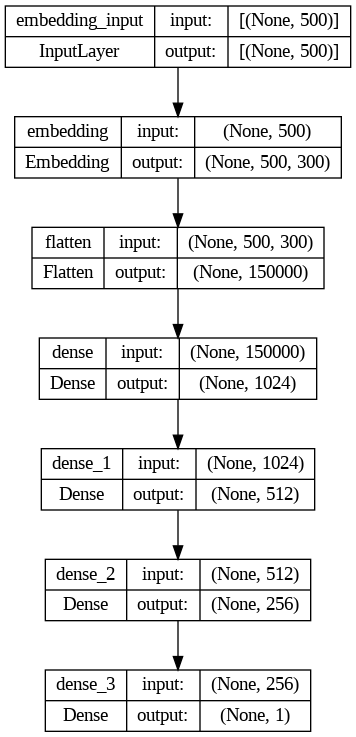

In [12]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 4s 26ms/step - loss: 0.7210 - mae: 0.8231 - val_loss: 0.7207 - val_mae: 0.8264
Epoch 2/20
47/47 [==============================] - 1s 22ms/step - loss: 0.7262 - mae: 0.8311 - val_loss: 0.7203 - val_mae: 0.8264
Epoch 3/20
47/47 [==============================] - 1s 22ms/step - loss: 0.7260 - mae: 0.8309 - val_loss: 0.7199 - val_mae: 0.8253
Epoch 4/20
47/47 [==============================] - 1s 22ms/step - loss: 0.7158 - mae: 0.8228 - val_loss: 0.7200 - val_mae: 0.8253
Epoch 5/20
47/47 [==============================] - 1s 22ms/step - loss: 0.7259 - mae: 0.8308 - val_loss: 0.7198 - val_mae: 0.8255
Epoch 6/20
47/47 [==============================] - 1s 22ms/step - loss: 0.7254 - mae: 0.8303 - val_loss: 0.7193 - val_mae: 0.8249
Epoch 7/20
47/47 [==============================] - 1s 22ms/step - loss: 0.5683 - mae: 0.6061 - val_loss: 0.0497 - val_mae: 0.1951
Epoch 8/20
47/47 [==============================] - 1s 22ms/step - loss: 0.0458 - m

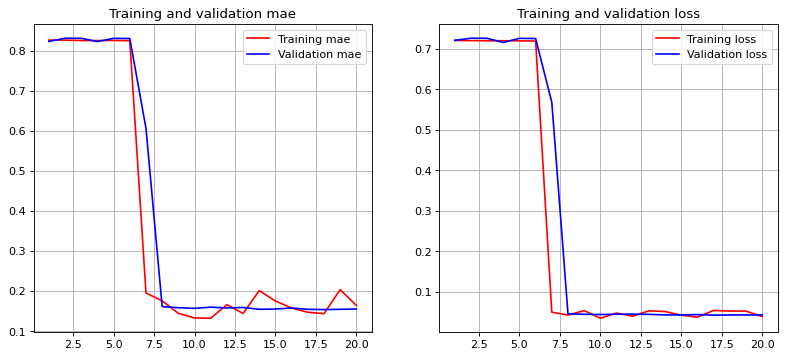

In [14]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [15]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.034920547157526016
min val loss = 0.04249228909611702
min train mae = 0.13215896487236023
min val mae = 0.15374326705932617


#### LSTM с embedding

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(1024,dropout=0.5))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 lstm (LSTM)                 (None, 1024)              5427200   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10133185 (38.66 MB)
Trainable params: 10

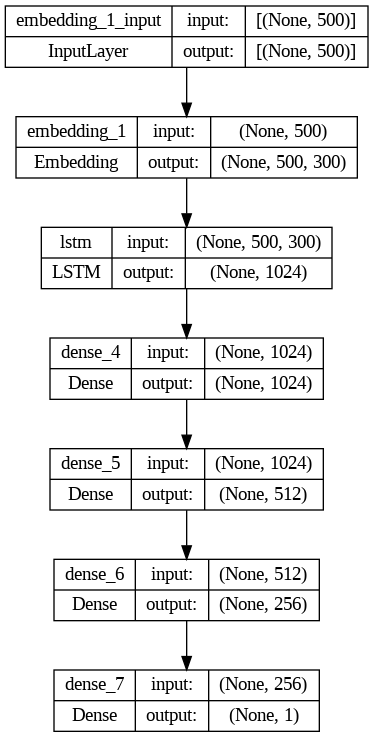

In [17]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 23s 425ms/step - loss: 0.0542 - mae: 0.1648 - val_loss: 0.0368 - val_mae: 0.1257
Epoch 2/20
47/47 [==============================] - 20s 417ms/step - loss: 0.0348 - mae: 0.1332 - val_loss: 0.0358 - val_mae: 0.1324
Epoch 3/20
47/47 [==============================] - 20s 417ms/step - loss: 0.0320 - mae: 0.1268 - val_loss: 0.0347 - val_mae: 0.1398
Epoch 4/20
47/47 [==============================] - 20s 418ms/step - loss: 0.0314 - mae: 0.1255 - val_loss: 0.0331 - val_mae: 0.1234
Epoch 5/20
47/47 [==============================] - 20s 418ms/step - loss: 0.0307 - mae: 0.1241 - val_loss: 0.0328 - val_mae: 0.1304
Epoch 6/20
47/47 [==============================] - 20s 418ms/step - loss: 0.0306 - mae: 0.1238 - val_loss: 0.0332 - val_mae: 0.1279
Epoch 7/20
47/47 [==============================] - 20s 419ms/step - loss: 0.0301 - mae: 0.1231 - val_loss: 0.0333 - val_mae: 0.1324
Epoch 8/20
47/47 [==============================] - 20s 419ms/step - 

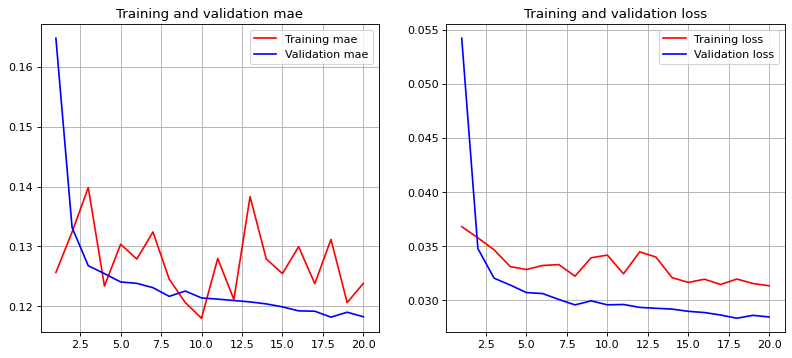

In [19]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [20]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.031345393508672714
min val loss = 0.028348704800009727
min train mae = 0.1180286779999733
min val mae = 0.11821001023054123


### Bi-LSTM с embedding

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(1024,dropout=0.5)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


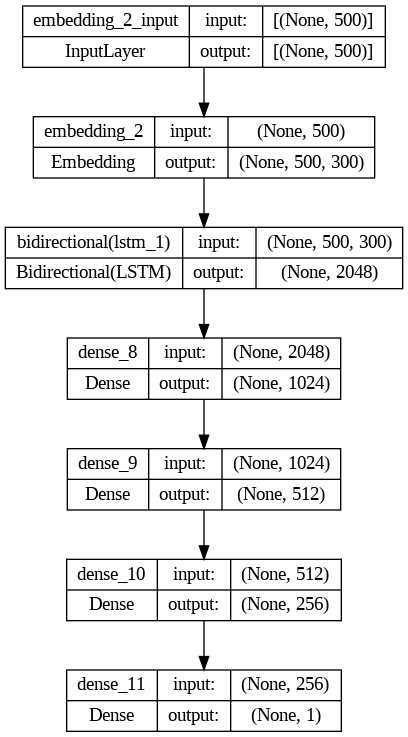

In [22]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 43s 845ms/step - loss: 0.1808 - mae: 0.2788 - val_loss: 0.0342 - val_mae: 0.1269
Epoch 2/20
47/47 [==============================] - 39s 829ms/step - loss: 0.0511 - mae: 0.1583 - val_loss: 0.0340 - val_mae: 0.1293
Epoch 3/20
47/47 [==============================] - 39s 830ms/step - loss: 0.0441 - mae: 0.1495 - val_loss: 0.0341 - val_mae: 0.1255
Epoch 4/20
47/47 [==============================] - 39s 830ms/step - loss: 0.0314 - mae: 0.1260 - val_loss: 0.0336 - val_mae: 0.1280
Epoch 5/20
47/47 [==============================] - 39s 831ms/step - loss: 0.0403 - mae: 0.1443 - val_loss: 0.0383 - val_mae: 0.1461
Epoch 6/20
47/47 [==============================] - 39s 829ms/step - loss: 0.0314 - mae: 0.1277 - val_loss: 0.0357 - val_mae: 0.1202
Epoch 7/20
47/47 [==============================] - 39s 831ms/step - loss: 0.0309 - mae: 0.1247 - val_loss: 0.0337 - val_mae: 0.1375
Epoch 8/20
47/47 [==============================] - 39s 831ms/step - 

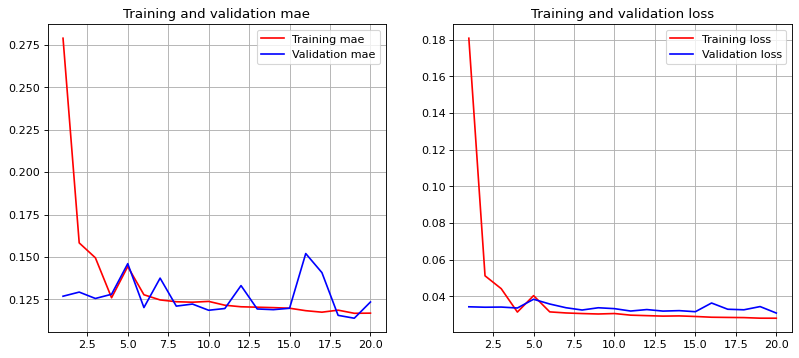

In [24]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [25]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.02799026295542717
min val loss = 0.030816730111837387
min train mae = 0.11682848632335663
min val mae = 0.11392165720462799


### Сверточная сеть


In [26]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(64, 3, activation='tanh', input_shape=(None, embedding_dim)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 5, activation='tanh'))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))


In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 8s 118ms/step - loss: 0.1575 - mae: 0.2675 - val_loss: 0.0346 - val_mae: 0.1261
Epoch 2/20
47/47 [==============================] - 5s 97ms/step - loss: 0.0310 - mae: 0.1252 - val_loss: 0.0338 - val_mae: 0.1269
Epoch 3/20
47/47 [==============================] - 4s 91ms/step - loss: 0.0294 - mae: 0.1212 - val_loss: 0.0331 - val_mae: 0.1291
Epoch 4/20
47/47 [==============================] - 4s 79ms/step - loss: 0.0281 - mae: 0.1180 - val_loss: 0.0328 - val_mae: 0.1234
Epoch 5/20
47/47 [==============================] - 4s 92ms/step - loss: 0.0269 - mae: 0.1147 - val_loss: 0.0325 - val_mae: 0.1199
Epoch 6/20
47/47 [==============================] - 4s 78ms/step - loss: 0.0253 - mae: 0.1108 - val_loss: 0.0319 - val_mae: 0.1239
Epoch 7/20
47/47 [==============================] - 3s 72ms/step - loss: 0.0238 - mae: 0.1075 - val_loss: 0.0358 - val_mae: 0.1205
Epoch 8/20
47/47 [==============================] - 3s 67ms/step - loss: 0.0224 - 

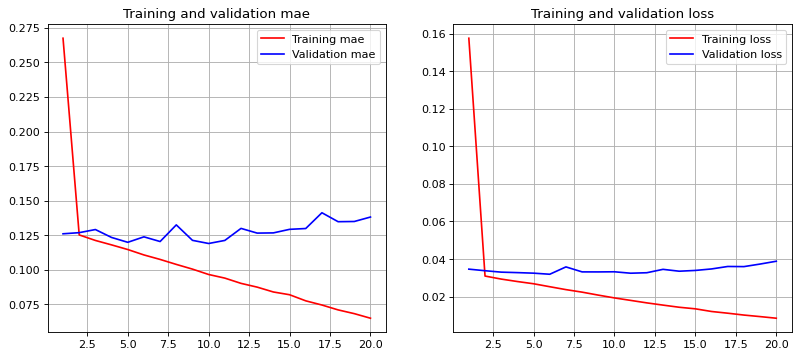

In [28]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [29]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.00853578932583332
min val loss = 0.03193148225545883
min train mae = 0.06501080095767975
min val mae = 0.11904356628656387
